# Measurement Error in Treatment Estimation
Julian Hsu
2025 Jan 12

One risks your experiment design may take is that you cannot accurately tell which users are in treatment or in control groups. The reason could be technical - treatment logging and assignment functions are not coordinated, or unavoidable because you cannot prevent control customers from seeing treatment experiences. This "treatment measurement error" will bias your estimates towards zero.

Using simulation data, I show the classical result from econometrics (one paper here: https://www.nber.org/papers/w2884) that the more inaccurate your treatment assignment is, the closer the estimate gets towards zero. This is because the users you think that are control and treatment are having the same experiences. Worst case scenario is among the users you think are in control, half are in control and half are in treatment. 



In [72]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:

def generate_data(n, true_effect):
    
    ## Generate latent treatment
    latent_treatment = np.random.normal(0,1, n)

    # Generate random treatment assignment
    true_treatment = (latent_treatment > 0 )
    
    # Introduce measurement error in the treatment variable
    ## Loop over different types of measurement noise
    obs_treatment_list = []
    for m in [0.5,1,2]:
        obs_treatment = (latent_treatment + np.random.normal(0,m,n)) > 0 
        obs_treatment_list.append(obs_treatment.astype(float))
    # Generate outcome variable with true treatment effect
    outcome = true_effect * true_treatment + np.random.normal(0, 1.5, n)
    
    return obs_treatment_list, true_treatment.astype(float), outcome
    
    
def estimate_effect(treatment, outcome):
    # Add a constant term for the intercept
    treatment = sm.add_constant(treatment)
    
    # Fit the linear regression model
    model = sm.OLS(outcome, treatment).fit()
    
    # Extract the coefficient and standard error of the treatment effect
    coef = model.params[1]
    std_err = model.bse[1]
    
    return coef, std_err

def simulate(n, true_effect, num_simulations):
    coefs_obs_list0 = []
    std_errs_obs_list0 = []
    coefs_obs_list1 = []
    std_errs_obs_list1 = []
    coefs_obs_list2 = []
    std_errs_obs_list2 = []    
    coefs_true_list = []
    std_errs_true_list = []

    
    for _ in range(num_simulations):
        obs_treatment, true_treatment, outcome = generate_data(n, true_effect)
        
        coef_obs0, std_err_obs0 = estimate_effect(obs_treatment[0], outcome)
        coefs_obs_list0.append(coef_obs0)
        std_errs_obs_list0.append(std_err_obs0)

        coef_obs1, std_err_obs1 = estimate_effect(obs_treatment[1], outcome)
        coefs_obs_list1.append(coef_obs1)
        std_errs_obs_list1.append(std_err_obs1)

        coef_obs2, std_err_obs2 = estimate_effect(obs_treatment[2], outcome)
        coefs_obs_list2.append(coef_obs2)
        std_errs_obs_list2.append(std_err_obs2)
        

        coef_true, std_err_true = estimate_effect(true_treatment, outcome)
        coefs_true_list.append(coef_true)
        std_errs_true_list.append(std_err_true)

        
    return coefs_obs_list0, std_errs_obs_list0, \
            coefs_obs_list1, std_errs_obs_list1, \
            coefs_obs_list2, std_errs_obs_list2, \
            coefs_true_list, std_errs_true_list



In [93]:
# Example usage
n = 50
true_effect = 1
num_simulations = 1000

Y = simulate(n, true_effect, num_simulations)

# print("Estimated Coefficients:", coefs)
# print("Standard Errors:", std_errs)


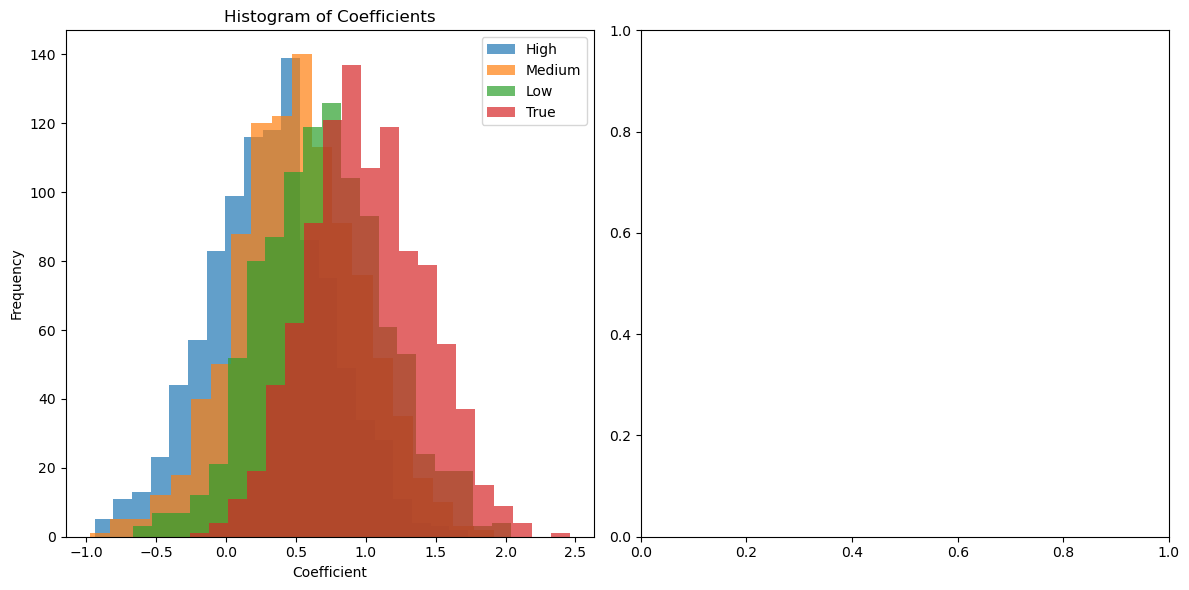

In [94]:

fig,ax = plt.subplots(ncols=2,nrows=1, figsize=(12,6))


ax[0].hist(Y[4], bins=20, alpha=0.7, label='High')
ax[0].hist(Y[2], bins=20, alpha=0.7, label='Medium')
ax[0].hist(Y[0], bins=20, alpha=0.7, label='Low')

ax[0].hist(Y[6], bins=20, alpha=0.7, label='True')
ax[0].set_title('Histogram of Coefficients')
ax[0].legend()
ax[0].set_xlabel('Coefficient')
ax[0].set_ylabel('Frequency')

# ax[1].hist(Y[1], bins=20, alpha=0.7, label='Obs')
# ax[1].hist(Y[3], bins=20, alpha=0.7, label='True')
# ax[1].set_title('Histogram of Standard Errors')
# ax[1].legend()
# ax[1].set_xlabel('Standard Error')
# ax[1].set_ylabel('Frequency')


plt.tight_layout()
plt.show()

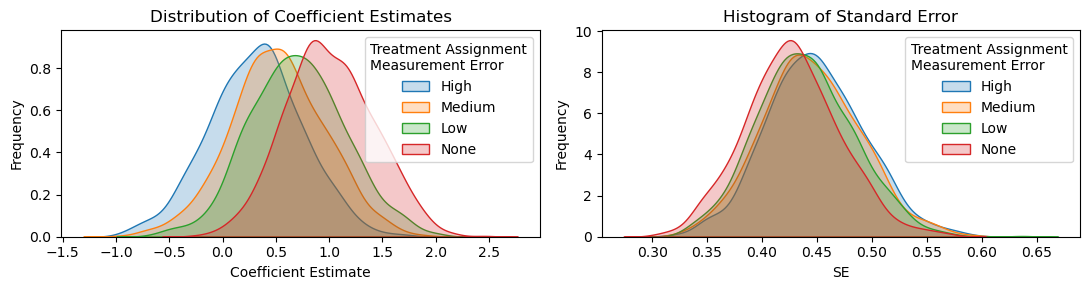

In [102]:


fig,ax = plt.subplots(ncols=2,nrows=1, figsize=(11,3))

sns.kdeplot(Y[4], shade=True, ax=ax[0], label='High')
sns.kdeplot(Y[2], shade=True, ax=ax[0], label='Medium')
sns.kdeplot(Y[0], shade=True, ax=ax[0], label='Low')
sns.kdeplot(Y[6], shade=True, ax=ax[0], label='None')

ax[0].set_title('Distribution of Coefficient Estimates')
ax[0].legend(title='Treatment Assignment\nMeasurement Error')
ax[0].set_xlabel('Coefficient Estimate')
ax[0].set_ylabel('Frequency')


sns.kdeplot(Y[5], shade=True, ax=ax[1], label='High')
sns.kdeplot(Y[3], shade=True, ax=ax[1], label='Medium')
sns.kdeplot(Y[1], shade=True, ax=ax[1], label='Low')
sns.kdeplot(Y[7], shade=True, ax=ax[1], label='None')


ax[1].set_title('Histogram of Standard Error')
ax[1].legend(title='Treatment Assignment\nMeasurement Error')
ax[1].set_xlabel('SE')
ax[1].set_ylabel('Frequency')



plt.tight_layout()
plt.show()
